<div style="text-align:center; font-size:36px; font-weight:bold; color:#4A4A4A; background-color:#fff6e4; padding:10px; border:3px solid #f5ecda; border-radius:6px">
    Medical Cost Prediction
    <p style="text-align:center; font-size:14px; font-weight:normal; color:#4A4A4A; margin-top:12px;">
        Author: Jens Bender <br> 
        Created: December 2025<br>
        Last updated: January 2026
    </p>
</div>

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Imports</h1>
</div>

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing (scikit-learn)
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder
)

# Model selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform  # for random hyperparameter values

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor 

# Model evaluation
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_percentage_error, 
    r2_score
)

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Data Loading and Inspection</h1>
</div>
<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Load the MEPS-HC 2023 data from the <code>h251.sas7bdat</code> file (SAS V9 format) into a Pandas DataFrame.
</div>

In [ ]:
try:
    # Load data using 'latin1' encoding because MEPS SAS files don't store text as UTF-8 and instead use Western European (ISO-8859-1), also known as latin1.
    df = pd.read_sas("../data/h251.sas7bdat", format="sas7bdat", encoding="latin1")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except pd.errors.ParserError:
    print("Error: The file content could not be parsed.")
except PermissionError:
    print("Error: Permission denied when accessing the file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 📌 Initial data inspection to understand the structure of the dataset and detect obvious issues.</p>

In [ ]:
# Show DataFrame info to check the number of rows and columns, data types and missing values
df.info()

In [ ]:
# Show top five rows of the data
df.head()

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Data Preprocessing</h1>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ <strong>Note:</strong> Kept column names in ALL CAPS to ensure consistency with official <b><a href="../docs/references/h251doc.pdf">MEPS documentation</a></b>, <b><a href="../docs/references/h251cb.pdf">codebook</a></b>, and <b><a href="../docs/references/data_dictionary.md">data dictionary</a></b>.
</div>

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Handling Duplicates</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Identify duplicates based on:
<ul>
    <li><strong>All columns</strong>: To detect exactly identical rows.</li>
    <li><strong>ID column only</strong>: To ensure that no two people share the same ID.</li>
    <li><strong>All columns except ID</strong>: To catch "hidden" duplicates where the same respondent may have been recorded twice under different IDs.</li>
</ul>
</div>

In [ ]:
# Identify duplicates based on all columns
df.duplicated().value_counts()

In [ ]:
# Identify duplicates based on the ID column
df.duplicated(["DUPERSID"]).value_counts()

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> ✅ No duplicates were found based on all columns or the ID column.</p>

In [ ]:
# Identify duplicates based on all columns except ID columns
id_columns = ["DUPERSID", "DUID", "PID", "PANEL"]
duplicates_without_id = df.duplicated(subset=df.columns.drop(id_columns), keep=False)
duplicates_without_id.value_counts()

In [ ]:
# Show duplicates
df[duplicates_without_id]

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> Detected 3 pairs (6 rows) of  duplicates based on all columns except ID columns. 
    <p style="margin-top:10px; margin-bottom:0px">
        These respondents have identical values across all 1,300+ columns except for their IDs. They appear to be young siblings (ages 1 and 5) from the same household with identical parent-reported health data, sample weights, and costs. Analysis suggests they are valid respondents rather than "ghost" records. Regardless, they will be excluded when filtering for the adult target population.
    </p>
</div>

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Variable Selection</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Filter the following 29 columns (out of 1,374):
    <ul style="margin-bottom:0px">
        <li><b>ID:</b> Unique identifier for each respondent (<code>DUPERSID</code>).</li>
        <li><b>Sample Weights:</b> Ensures population representativeness (<code>PERWT23F</code>).</li>
        <li><b>Candidate Features:</b> 26 variables selected for their consumer accessibility, beginning-of-year measurement, and predictive power.</li> 
        <li><b>Target Variable:</b> Total out-of-pocket health care costs (<code>TOTSLF23</code>).</li>
    </ul>
    <br>
    <b>Rationale:</b> For a detailed breakdown of the target variable selection and feature selection criteria, see the <b><a href="../docs/specs/technical_specifications.md">Technical Specifications</a></b> and <b><a href="../docs/research/candidate_features.md">Candidate Features Research</a></b>.
</div>

In [ ]:
# List of columns to keep 
columns_to_keep = [
    # 1. ID
    "DUPERSID",
    
    # 2. Sample Weights
    "PERWT23F", 

    # 3 Candidate Features.
    # 3.1 Demographics
    "AGE23X", "SEX", "REGION23", "MARRY31X",
    
    # 3.2 Socioeconomic
    "POVCAT23", "FAMSZE23", "HIDEG", "EMPST31",
    
    # 3.3 Insurance & Access
    "INSCOV23", "HAVEUS42",
    
    # 3.4 Perceived Health & Lifestyle
    "RTHLTH31", "MNHLTH31", "ADSMOK42",
    
    # 3.5 Limitations & Symptoms
    "ADLHLP31", "IADLHP31", "WLKLIM31", "COGLIM31", "JTPAIN31_M18",
    
    # 3.6 Chronic Conditions
    "HIBPDX", "CHOLDX", "DIABDX_M18", "CHDDX", "STRKDX", "CANCERDX", "ARTHDX", "ASTHDX", 
    
    # 4. Healthcare Expenditure (Target)
    "TOTSLF23"
]

# Drop all other columns (keeping 29 out of 1,374)
df = df[columns_to_keep]

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Target Population Filtering</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Filter rows to match the target population (target audience for app) based on the following criteria:
    <ul style="margin-bottom:0px">
        <li><b>Positive person weight (<code>PERWT23F > 0</code>):</b> Drop respondents with a person weight of zero (i.e., 456 respondents). These individuals are considered "out-of-scope" for the full-year population (e.g., they joined the military, were institutionalized, or moved abroad).</li>
        <li><b>Adults (<code>AGE23X >= 18</code>):</b> Drop respondents under age 18 (i.e., 3796 respondents), as the medical cost planner app targets adults.</li>
    </ul>
    <br>
    <b>Note:</b> Keeps 14,768 out of 18,919 respondents.
</div>

In [ ]:
# Filter DataFrame 
df = df[(df["PERWT23F"] > 0) & (df["AGE23X"] >= 18)].copy() 

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Handling Data Types</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Identify and convert incorrect storage data types.
    <ul>
        <li><b>ID:</b> <code>DUPERSID</code> is an identifier, not a quantity. Converting them to <code>string</code> prevents unintended math.</li>
        <li><b>Sample Weights:</b> <code>PERWT23F</code> contains decimal precision critical for population-level estimates. Must remain <code>float</code>.</li>
        <li><b>Candidate Features:</b> The SAS loader stored all 26 features as floats by default. Although many features are categorical and represent integer codes (e.g., 1=Male, 2=Female), they are maintained as <code>float</code> for three practical reasons:
            <ul>
                <li>Missing Value Compatibility: In standard Pandas, <code>np.nan</code> is a floating-point object. Assigning it to an integer column automatically casts back to <code>float64</code>.</li>
                <li>Data Preprocessing Consistency: scikit-learn transformers (e.g., <code>SimpleImputer</code>, <code>StandardScaler</code>) internally use floats and automatically convert numerical inputs to <code>float</code>, even when using <code>set_config(transform_output="pandas")</code>. Keeping them as floats avoids redundant type casting.</li>
                <li>Model Consistency: Most machine learning models (e.g., XGBoost, Linear Regression) internally use floats and automatically convert numerical inputs to <code>float</code> during training and inference. Keeping them as floats avoids redundant type casting.</li>
            </ul>
        </li>
        <li><b>Target Variable:</b> <code>TOTSLF23</code> was stored as <code>float</code> by the SAS loader. Although it is rounded to whole dollars in the MEPS data, it is kept as <code>float</code> for data preprocessing and model consistency and to avoid redundant type casting, as ML models deliver <code>float</code> predictions during training and inference.</li>
    </ul>
</div>

In [ ]:
# Identify storage data types (defaulted to float/object by SAS loader)
df.dtypes

In [ ]:
# Convert ID to string
df["DUPERSID"] = df["DUPERSID"].astype(str)

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h2 style="margin:0px">Standardizing Missing Values</h1>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ <b>Pandas Missing Value Types</b>:
    <ul style="margin-bottom:0px">
        <li><b>np.nan:</b> Standard missing value indicator (technically a float); often the default in Pandas for numerical data.</li>
        <li><b>pd.NA:</b> Unified missing value indicator for modern nullable data types (mostly integer and boolean).</li>
        <li><b>None:</b> Python's native type; often used for object and string data.</li>
        <li><b>pd.NaT:</b> For datetime and timedelta data types.</li>
    </ul>
    <br>
    ℹ️ <b>MEPS Missing Value Codes:</b>
    <ul style="margin-bottom:0px">
        <li><b>-1 INAPPLICABLE:</b> Variable does not apply (structural skip).</li>
        <li><b>-7 REFUSED:</b> Person refused to answer.</li>
        <li><b>-8 DON'T KNOW:</b> Person did not know the answer.</li>
        <li><b>-9 NOT ASCERTAINED:</b> Administrative or technical error in collection.</li>
        <li><b>-15 CANNOT BE COMPUTED:</b> Incomplete data for a constructed variable.</li>
    </ul>
</div>

In [ ]:
# Identify Pandas missing values
df.isnull().sum()

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 <b>Handle MEPS-Specific Missing Values and Skip Patterns</b>
    <br><br>
    <b>Understanding Skip Patterns</b><br>
    Skip patterns (routing logic) are used in surveys to ensure respondents only answer questions relevant to them, reducing burden and improving data quality. For analysis, this creates "structural" missingness (coded as -1 Inapplicable) can often be recovered by looking at the respondent's path through the survey.
    <br><br>
    <b>Recovering Implied Values:</b>  
    <ul>
        <li><b>Smoker (<code>ADSMOK42</code>):</b> This question is only asked if the respondent already confirmed smoking 100+ cigarettes in their life. Those who said "No" skip this and are coded -1. In this project, these "Never Smokers" are mapped to "No" (2).</li>
        <li><b>Joint Pain (<code>JTPAIN31_M18</code>):</b> Respondents who already reported an arthritis diagnosis (<code>ARTHDX = 1</code>) earlier in the interview skip this question and are coded -1. Since arthritis inherently involves joint symptoms, these values are mapped to "Yes" (1).</li>
    </ul>
</div>

In [ ]:
# Recover implied values
# Smoker: Convert -1 (Never Smoker) to 2 (No)
df.loc[df["ADSMOK42"] == -1, "ADSMOK42"] = 2

# Joint Pain: Convert -1 to 1 (Yes) only if they have Arthritis 
df.loc[(df["JTPAIN31_M18"] == -1) & (df["ARTHDX"] == 1), "JTPAIN31_M18"] = 1

In [ ]:
# Identify MEPS missing values 
missing_codes = [-1, -7, -8, -9, -15]
missing_frequency_df = pd.DataFrame({code: (df == code).sum() for code in missing_codes})
missing_frequency_df["TOTAL"] = missing_frequency_df.sum(axis=1)
missing_frequency_df["PERCENTAGE"] = (missing_frequency_df["TOTAL"] / len(df) * 100).round(2)
missing_frequency_df.sort_values("TOTAL", ascending=False) 

In [ ]:
# Convert all MEPS missing codes to np.nan
df = df.replace(missing_codes, np.nan)

# Verify results
df.isnull().sum().sort_values(ascending=False)

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Train-Validation-Test Split</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px">
    📌 Split the data into 80% for training, 10% for validation, and 10% for testing.
    <table style="margin-left:0; margin-top:20px; margin-bottom:20px">
        <tr>
            <th style="background-color:#f5ecda;">Data</th>
            <th style="background-color:#f5ecda;">Size (%)</th>
            <th style="background-color:#f5ecda;">Size (Total)</th>
        </tr>
        <tr>
            <td style="background-color:#fff6e4;">Training Set</td>
            <td style="background-color:#fff6e4;">80%</td>
            <td style="background-color:#fff6e4;">11,814</td>
        </tr>
        <tr>
            <td style="background-color:#f5ecda;">Validation Set</td>
            <td style="background-color:#f5ecda;">10%</td>
            <td style="background-color:#f5ecda;">1,477</td>
        </tr>
        <tr>
            <td style="background-color:#fff6e4;">Test Set</td>
            <td style="background-color:#fff6e4;">10%</td>
            <td style="background-color:#fff6e4;">1,477</td>
        </tr>
    </table>
</div>

In [ ]:
# Split the data into X features and y target
X = df.drop("TOTSLF23", axis=1)
y = df["TOTSLF23"]

In [ ]:
# Split the data into training and temporary sets (80% train, 20% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets (50% each)
# Note: This accomplishes a 80% training, 10% validation and 10% test set size
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Delete the temporary data to free up memory
del X_temp, y_temp

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Exploratory Data Analysis (EDA)</h1>
</div>

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Univariate EDA</h2>
</div>

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ Analyze the distribution of a single column using descriptive statistics and visualizations.
</div>

<div style="background-color:#4e8ac8; color:white; padding:10px; border-radius:6px;">
    <h3 style="margin:0px">Sample Weights</h3>
</div> 

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Examine descriptive statistics and visualize the distribution of the sample weights. 
</div>

In [ ]:
# Descriptive statistics of sample weights
df["PERWT23F"].describe()

In [ ]:
# Sum of sample weights
df["PERWT23F"].sum()

In [ ]:
# Histogram of sample weights
sns.histplot(df["PERWT23F"])

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> Using sample weights in machine learning models is essential to correct for oversampling and ensure that predictions are representative of the U.S. civilian noninstitutionalized adult population. 
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Sum:</b> The sum of all weights is approximately 260 million, representing the estimated U.S. adult population in 2023.</li>
        <li><b>Median:</b> A typical respondent represents roughly 14,600 people.</li>
        <li><b>Right-Skewed Distribution:</b> The mean (17,584) is higher than the median, confirming that a small number of respondents represent a disproportionately large share of the population.</li>
        <li><b>Sampling Strategy:</b> Weights range from 502 to 131,657. This reflects MEPS's strategy of oversampling specific subgroups to ensure reliable estimates for minority or high-need populations.</li>
        <li><b>Bias Correction:</b> Because weights vary significantly (std ≈ 12,334), unweighted models or averages would be biased. Using <code>sample_weight</code> during training ensures the model's loss function prioritizes population representativeness.</li>
    </ul>
</div>

<div style="background-color:#4e8ac8; color:white; padding:10px; border-radius:6px;">
    <h3 style="margin:0px">Target Variable</h3>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ Examine descriptive statistics and visualize the distribution of total out-of-pocket health care costs.
    <br>
    <b>Note:</b> Unless otherwise specified, all descriptive statistics and insights in this section refer to population-level estimates (calculated using sample weights) to ensure representativeness of the U.S. adult population.
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Descriptive Statistics</strong> <br>
    📌 Examine descriptive statistics of total out-of-pocket health care costs, both on sample-level and population-level. 
</div>

In [ ]:
# Helper function to calculate weighted quantiles (using numpy; not available in pandas)
def weighted_quantile(variable, weights, quantile):
    sorter = np.argsort(variable)
    values = variable.iloc[sorter]
    weights = weights.iloc[sorter]
    cumulative_weight = np.cumsum(weights) - 0.5 * weights
    cumulative_weight /= np.sum(weights)
    return np.interp(quantile, cumulative_weight, values)

# Helper function to calculate weighted standard deviation (using numpy; not available in pandas)
def weighted_std(variable, weights):
    weighted_mean = np.average(variable, weights=weights)
    weighted_variance = np.average((variable - weighted_mean)**2, weights=weights)
    return np.sqrt(weighted_variance)

# Calculate weighted (population) statistics
pop_mean = np.average(df["TOTSLF23"], weights=df["PERWT23F"])
pop_std = weighted_std(df["TOTSLF23"], weights=df["PERWT23F"])
pop_p25 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.25)
pop_median = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.5)
pop_p75 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.75)
pop_p95 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.95)
pop_p99 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.99)
pop_p999 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.999)

# Calculate sample (unweighted) quantiles
sample_p95 = df["TOTSLF23"].quantile(0.95)
sample_p99 = df["TOTSLF23"].quantile(0.99)
sample_p999 = df["TOTSLF23"].quantile(0.999)

# Calculate total costs (sum)
sample_total_costs = df["TOTSLF23"].sum()
df["pop_costs"] = df["TOTSLF23"] * df["PERWT23F"]  
pop_total_costs = df["pop_costs"].sum()

# Create comparison table: Sample vs. population statistics 
sample_vs_population_stats = pd.DataFrame({
    "Sample (Unweighted)": [
        len(df),
        df["TOTSLF23"].mean(),
        df["TOTSLF23"].std(),
        df["TOTSLF23"].min(),
        df["TOTSLF23"].quantile(0.25),
        df["TOTSLF23"].median(),
        df["TOTSLF23"].quantile(0.75),
        sample_p95,
        sample_p99,
        sample_p999,
        df["TOTSLF23"].max(),
        sample_total_costs
    ],
    "Population (Weighted)": [
        df["PERWT23F"].sum(),  # sum of weights = count of target population
        pop_mean,
        pop_std,
        df["TOTSLF23"].min(),  # min is identical
        pop_p25,
        pop_median,
        pop_p75,
        pop_p95,
        pop_p99,
        pop_p999,
        df["TOTSLF23"].max(),  # max is identical
        pop_total_costs
    ]
}, index=["count", "mean", "std", "min", "25%", "50%", "75%", "95%", "99%", "99.9%", "max", "sum"])

# Display table
# Formatting: Comma thousand separator and rounded to zero decimals (sample sum in Millions, population sum in Billions with one decimal)
sample_vs_population_stats.style.format("{:,.0f}") \
    .format(lambda x: f"${x/1e6:.1f}M", subset=("sum", "Sample (Unweighted)")) \
    .format(lambda x: f"${x/1e9:.1f}B", subset=("sum", "Population (Weighted)"))

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The descriptive statistics reveal a highly skewed and volatile cost distribution, emphasizing the importance of using sample weights for representative estimates.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Right Skewness:</b> The population mean (\$1,106) is over 4x higher than the median (\$251), indicating that a few high-cost cases disproportionately influence the average.</li>
        <li><b>Sampling Bias Correction:</b> The mean, median and most percentiles (up to the 99th) are lower in the population compared to the sample (e.g., mean drops from \$1,160 to \$1,106), showing that the raw sample slightly over-represented most higher-cost individuals. However, the 99.9th percentile and standard deviation are actually higher in the population, revealing that the raw sample slightly under-represented the most extreme tail risk of the "super-spenders" (top 0.1%).</li>
        <li><b>Extreme Financial Risk:</b> While 75% of the population spends less than \$1,042 out-of-pocket, the maximum reaches \$104,652, highlighting severe financial exposure for a minority.</li>
        <li><b>High Dispersion:</b> The standard deviation (~\$3,000) is nearly triple the mean, reflecting the inherent unpredictability and high variance in health care costs.</li>
    </ul>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Histogram</strong> <br> 
    📌 Visualize the distribution of out-of-pocket health care costs. 
</div>

In [ ]:
# Histogram: Sample vs. Population (overlayed)
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))

# Population histogram 
sns.histplot(
    data=df, x="TOTSLF23", weights="PERWT23F", label="Population (Weighted)",
    stat="probability", bins=50, color="#4e8ac8", alpha=0.5, element="bars"
)

# Sample histogram 
sns.histplot(
    data=df, x="TOTSLF23", label="Sample (Unweighted)",
    stat="probability", bins=50, color="#2c699d", alpha=0.8, element="step"
)

# Formatting
plt.title("Distribution of Out-of-Pocket Costs")
plt.xlabel("Out-of-Pocket Costs")
plt.ylabel("Share")

# Add population mean and median lines for context
plt.axvline(pop_mean, color="#e63946", linestyle="--", alpha=0.8, label=f"Population Mean: ${pop_mean:,.0f}")
plt.axvline(pop_median, color="#fb8500", linestyle="--", alpha=0.8, label=f"Population Median: ${pop_median:,.0f}")

plt.legend()

# Format X-axis as dollars with comma thousand separator rounded to zero decimals
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
# Format Y-axis as percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.grid(True, alpha=0.3)
plt.show()

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    ℹ️ Note: Due to the zero-inflation (22% have \$0 costs) and the extremely heavy tail (max \$104k), the full distribution is heavily compressed into the first few bins.<br>
    📌 Visualize the "typical" distribution excluding zero costs and the top 5% of spenders (zooming in).
</div>

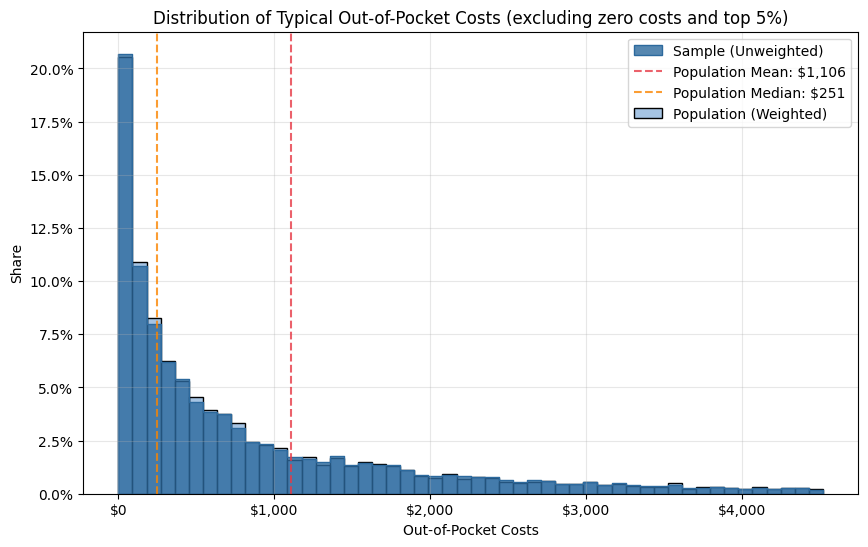

In [47]:
# Histogram of typical range (excluding zero costs and top 5%)
plot_data = df[(df["TOTSLF23"] > 0) & (df["TOTSLF23"] < pop_p95)].copy()

plt.figure(figsize=(10, 6))

# Population histogram 
sns.histplot(
    data=plot_data, x="TOTSLF23", weights="PERWT23F", label="Population (Weighted)",
    stat="probability", bins=50, color="#4e8ac8", alpha=0.5, element="bars"
)

# Sample histogram
sns.histplot(
    data=plot_data, x="TOTSLF23", label="Sample (Unweighted)",
    stat="probability", bins=50, color="#2c699d", alpha=0.8, element="step"
)

# Add population mean and median lines for context
plt.axvline(pop_mean, color="#e63946", linestyle="--", alpha=0.8, label=f"Population Mean: ${pop_mean:,.0f}")
plt.axvline(pop_median, color="#fb8500", linestyle="--", alpha=0.8, label=f"Population Median: ${pop_median:,.0f}")

# Formatting
plt.title("Distribution of Typical Out-of-Pocket Costs (excluding zero costs and top 5%)")
plt.xlabel("Out-of-Pocket Costs")
plt.ylabel("Share")
plt.legend()

# Format X-axis as dollars with thousand separator 
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
# Format Y-axis as percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True, alpha=0.3)
plt.show()

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The "typical" distribution (excluding zeros and the top 5%) remains heavily right-skewed with a massive share of the population still concentrated in the lowest cost bins. To get a better picture, I will plot a Lorenz Curve to quantify the overall concentration of healthcare costs and conduct in-depth Zero-Cost Analysis and Top 1% Analysis.
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Zero Costs Analysis</strong> <br>
    📌 Deeper analysis of people with zero out-of-pocket health care costs (sample and population). 
</div>

In [ ]:
# Zero costs analysis
zero_costs_df = pd.DataFrame({
    "Sample (Unweighted) Count": [len(df[df["TOTSLF23"] == 0]), len(df[df["TOTSLF23"] > 0])],
    "Population (Weighted) Count": [df[df["TOTSLF23"] == 0]["PERWT23F"].sum(), df[df["TOTSLF23"] > 0]["PERWT23F"].sum()],
    "Sample (Unweighted) %": [
        (df["TOTSLF23"] == 0).mean() * 100,
        (df["TOTSLF23"] > 0).mean() * 100
    ],
    "Population (Weighted) %": [
        (df.loc[df["TOTSLF23"] == 0, "PERWT23F"].sum() / df["PERWT23F"].sum()) * 100,
        (df.loc[df["TOTSLF23"] > 0, "PERWT23F"].sum() / df["PERWT23F"].sum()) * 100
    ]
}, index=["Zero Costs", "Positive Costs"]).round(2)

zero_costs_df.style.format({
    "Sample (Unweighted) Count": "{:,.0f}",
    "Population (Weighted) Count": "{:,.0f}",
    "Sample (Unweighted) %": "{:.1f}%",
    "Population (Weighted) %": "{:.1f}%"
})

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The large proportion of zeros confirms that the target variable is zero-inflated.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>High Zero-Cost Prevalence:</b> Over 22% of the U.S. adult population (approx. 58 million people) had zero out-of-pocket health care costs in 2023.</li>
        <li><b>Correction of Sampling Bias:</b> The weighted population percentage (22.3%) is higher than the unweighted sample percentage (20.7%), indicating that zero-cost individuals were slightly under-represented in the raw survey data.</li>
        <li><b>Modeling Implications:</b> The zero-inflated target variable suggests that a two-part modeling strategy (e.g., predicting the probability of any spend vs. the amount of spend) may be more effective than a single standard regression.</li>
    </ul>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Top 1% Analysis</strong> <br>
    📌 Deeper analysis of respondents in the top 1% and top 0.1% of out-of-pocket health care costs to understand extreme tail risk. 
</div>

In [ ]:
# Top 1% analysis
# Sample (Unweighted)
sample_top_1_costs = df[df["TOTSLF23"] >= sample_p99]["TOTSLF23"].sum()
sample_top_01_costs = df[df["TOTSLF23"] >= sample_p999]["TOTSLF23"].sum()

# Population (Weighted)
pop_top_1_costs = df[df["TOTSLF23"] >= pop_p99]["pop_costs"].sum()
pop_top_01_costs = df[df["TOTSLF23"] >= pop_p999]["pop_costs"].sum()

# Create comparison table
top_1_df = pd.DataFrame({
    "Sample (Unweighted)": [
        sample_p99,
        sample_top_1_costs / 1e6,  # Millions
        (sample_top_1_costs / sample_total_costs) * 100,
        sample_p999,
        sample_top_01_costs / 1e6,  # Millions
        (sample_top_01_costs / sample_total_costs) * 100
    ],
    "Population (Weighted)": [
        pop_p99,
        pop_top_1_costs / 1e9,  # Billions
        (pop_top_1_costs / pop_total_costs) * 100,
        pop_p999,
        pop_top_01_costs / 1e9,  # Billions
        (pop_top_01_costs / pop_total_costs) * 100
    ]
}, index=[
    "Top 1% Threshold",
    "Top 1% Total Costs",
    "Top 1% Share of Costs",
    "Top 0.1% Threshold",
    "Top 0.1% Total Costs",
    "Top 0.1% Share of Costs"
])

# Style the table
top_1_df.style.format("${:,.0f}", subset=(["Top 0.1% Threshold", "Top 1% Threshold"], slice(None))) \
                 .format("${:,.1f}M", subset=(["Top 0.1% Total Costs", "Top 1% Total Costs"], "Sample (Unweighted)")) \
                 .format("${:,.1f}B", subset=(["Top 0.1% Total Costs", "Top 1% Total Costs"], "Population (Weighted)")) \
                 .format("{:.1f}%", subset=(["Top 0.1% Share of Costs", "Top 1% Share of Costs"], slice(None)))

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> Extreme cost concentration in the tail of the distribution.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>The 1% Rule:</b> The top 1% of spenders —those spending over ~\$13k—account for roughly 20% of all out-of-pocket costs.</li>
        <li><b>The Hyper-Tail (Top 0.1%):</b> The top 0.1% of spenders—those spending over ~\$39k—account for a disproportionate share of total costs (approx. 5%). This highlights that the tail is not just long, but extremely heavy.</li>
        <li><b>Extreme Outliers:</b> The gap between the 99th percentile (\$12,868) and the maximum (\$104,652) is massive. These "super-spenders" represent a significant challenge for predictive modeling, as a single misprediction here could lead to very high error (RMSE).</li>
        <li><b>Financial Risk Benchmarks:</b> These thresholds provide a clear picture of what "catastrophic" spending looks like in the U.S. adult population.</li>
    </ul>
</div>

In [ ]:
# Inspecting the "Super-Spenders" (Everyone in the Top 0.1% of the population)
# This helps us identify if there are common patterns (e.g., age or chronic conditions) among extreme spenders.
chronic_cols = ["HIBPDX", "CHOLDX", "DIABDX_M18", "CHDDX", "STRKDX", "CANCERDX", "ARTHDX", "ASTHDX"]
df["CHRONIC_COUNT"] = (df[chronic_cols] == 1).sum(axis=1)

super_spenders = df[df["TOTSLF23"] >= pop_p999].sort_values("TOTSLF23", ascending=False)
super_spenders[["TOTSLF23", "PERWT23F", "AGE23X", "SEX", "INSCOV23", "CHRONIC_COUNT"] + chronic_cols]

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The "Super-Spender" profiles reveal a critical dichotomy for predictive modeling.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Acute vs. Chronic Drivers:</b> We see two distinct profiles: "Multi-Morbid" elderly (e.g., 85yo with 7 conditions) and "Acute Shock" individuals (young with 0-1 conditions). This suggests that while chronic disease predicts higher costs on average, the extreme tail is often driven by unpredictable acute events (accidents, rare surgeries).</li>
        <li><b>The "Black Swan":</b> The absolute maximum outlier is a 24-year-old with only 1 chronic condition but ~\$104k in out-of-pocket costs. With a high sample weight (~31k), this single respondent represents over 30,000 people. This is a "Black Swan" event—atypical and unpredictable—that could severely impair model performance if not handled carefully. Mathematically, because RMSE squares the error, a single \$50,000 prediction error on the top outlier adds as much to the loss function as \$1,500 errors on 1,000 different people. The model will be naturally "obsessed" with fitting these few outliers at the expense of the general population.</li>
        <li><b>The Insurance Paradox:</b> Surprisingly, only one of the top 15 spenders is uninsured (<code>INSCOV23=3</code>). Most even have private insurance (n=11). This shows that high out-of-pocket costs in the U.S. are not just a problem for the uninsured, but often hit those with coverage who face high deductibles, co-pays, or non-covered services.</li>
        <li><b>Strategy:</b> To prevent these outliers from dominating the training, we must consider target transformations (Log/Box-Cox) or robust regression techniques that "downweight" the influence of extreme residuals.</li>
    </ul>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Cost Concentration Analysis</strong> <br>
    📌 Examine the cost thresholds, totals, and shares for the top 1%, 5%, 10%, 20%, and 50% of spenders (sample and population). 
</div>

In [ ]:
# Cost Concentration Benchmarks 
percentiles = [0.99, 0.95, 0.9, 0.8, 0.5]
stats = []

sample_total_costs = df["TOTSLF23"].sum()
pop_total_costs = df["pop_costs"].sum()

for p in percentiles:
    # Calculate Thresholds
    sample_threshold = df["TOTSLF23"].quantile(p)
    pop_threshold = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], p)
    
    # Sample Share (Unweighted)
    sample_share = (df[df["TOTSLF23"] >= sample_threshold]["TOTSLF23"].sum() / sample_total_costs) * 100
    
    # Population Share (Weighted)
    pop_share = (df[df["TOTSLF23"] >= pop_threshold]["pop_costs"].sum() / pop_total_costs) * 100
    
    stats.append({
        "Top X%": f"Top {(1-p)*100:.0f}%",
        "Threshold (Sample)": sample_threshold,
        "Threshold (Population)": pop_threshold,
        "Share of Total Costs (Sample)": sample_share,
        "Share of Total Costs (Population)": pop_share
    })

# Set "Top X%" as DataFrame index
cost_concentration_df = pd.DataFrame(stats).set_index("Top X%")

# Show table with formatted values
cost_concentration_df.style.format({
    "Threshold (Sample)": "${:,.0f}",
    "Threshold (Population)": "${:,.0f}",
    "Share of Total Costs (Sample)": "{:.1f}%",
    "Share of Total Costs (Population)": "{:.1f}%"
})

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Lorenz Curve</strong> <br>
    📌 Plot the Lorenz Curve. 
</div>

In [ ]:
# Lorenz Curve
import matplotlib.ticker as mtick

# Sort costs from lowest to highest
sorted_costs = df["TOTSLF23"].sort_values()

# Calculate cumulative percentage of population and costs
cum_pop = np.arange(1, len(sorted_costs) + 1) / len(sorted_costs) * 100
cum_costs = sorted_costs.cumsum() / sorted_costs.sum() * 100

# Plotting
plt.figure(figsize=(8, 6))

# The Lorenz Curve
plt.plot(cum_pop, cum_costs, label="Lorenz Curve (Actual Costs)", color="#084594", lw=2)

# The Line of Equality (Perfectly equal spend)
plt.plot([0, 100], [0, 100], linestyle="--", color="gray", label="Line of Equality")

# Fill the area for visual emphasis
plt.fill_between(cum_pop, cum_costs, cum_pop, color="#084594", alpha=0.1)

# Customization
plt.title("Lorenz Curve: Concentration of Out-of-Pocket Costs")
plt.xlabel("Cumulative % of Population (Ordered from Lowest to Highest Costs)")
plt.ylabel("Cumulative % of Total Costs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 101, 10))  # set grid lines every 10%
plt.yticks(range(0, 101, 10))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())  # format axis tick labels as percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> High inequality in out-of-pocket health care spending.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Top 1% Concentration:</b> The top 1% of respondents account for 20% of total out-of-pocket costs.</li>
        <li><b>The 80/20 Rule:</b> The top 20% of respondents account for roughly 80% of total costs.</li>
        <li><b>Zero Costs:</b> 21% of respondents have $0 in out-of-pocket costs.</li>
        <li><b>Bottom 50%:</b> The bottom half of the population collectively accounts for less than 5% of total costs.</li>
    </ul>
</div> 